In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from mlxtend.plotting import plot_confusion_matrix
from torchvision import models
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import cv2
from sklearn.model_selection import train_test_split
import seaborn as sn

In [2]:
train_data = pd.read_csv('../archive (7)/emnist-bymerge-train2.csv', header=None)

# Select a subset of the data
l = train_data[0].head(10000)
d = train_data.drop(0, axis=1).head(10000)

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
               'a','b','d','e','f','g','h','n','q','r','t']


In [3]:
x = d.values.reshape(-1, 28, 28).astype('float32')

In [4]:
y = l.values.astype('int')

In [5]:
x_train, x_20_train, y_train, y_20_train = train_test_split(x, y, test_size=0.2, random_state=123)


In [6]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        # Resize image to 224x224 using OpenCV
        img_resized = cv2.resize(img, (224, 224))
        # Normalize image to [0, 1]
        img_normalized = img_resized / 255.0
        # Add a channel dimension
        img_expanded = np.expand_dims(img_normalized, axis=0)
        processed_images.append(img_expanded)
    return np.array(processed_images)

x_train = preprocess_images(x_train)
x_20_train = preprocess_images(x_20_train)


In [7]:
x_train_tensor = torch.tensor(x_train).float()
x_20_train_tensor = torch.tensor(x_20_train).float()
y_train_tensor = torch.tensor(y_train)
y_20_train_tensor = torch.tensor(y_20_train)



In [8]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
twenty_percent_train_dataset = TensorDataset(x_20_train_tensor, y_20_train_tensor)



In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
twenty_percent_train_loader = DataLoader(twenty_percent_train_dataset, batch_size=64, shuffle=False)


In [10]:
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
model.classifier[6] = nn.Linear(4096, 47)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [12]:
device = torch.device('cpu')
model.to(device)


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
num_epoch = 5
for epoch in range(num_epoch):
    train_loss = 0.0
    train_corrects = 0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_corrects += torch.sum(preds == labels.data)
    epoch_loss = train_loss / len(train_loader.dataset)
    epoch_acc = train_corrects.double() / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epoch} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')


Epoch 1/5 - Loss: 1.6963, Acc: 0.5407
Epoch 2/5 - Loss: 0.6362, Acc: 0.7856
Epoch 3/5 - Loss: 0.5020, Acc: 0.8247
Epoch 4/5 - Loss: 0.4059, Acc: 0.8520
Epoch 5/5 - Loss: 0.3453, Acc: 0.8708


In [14]:
model.eval()
twenty_percent_train_corrects = 0
y_true_20_train, y_pred_20_train = [], []
with torch.no_grad():
    for inputs, labels in twenty_percent_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        twenty_percent_train_corrects += torch.sum(preds == labels.data)
        y_true_20_train.extend(labels.cpu().numpy())
        y_pred_20_train.extend(preds.cpu().numpy())
twenty_percent_train_acc = twenty_percent_train_corrects.double() / len(twenty_percent_train_loader.dataset)
print(f'20% Training Accuracy: {twenty_percent_train_acc.item():.4f}')


20% Training Accuracy: 0.8470


In [15]:
from sklearn.metrics import classification_report 
report = classification_report(y_true_20_train, y_pred_20_train, target_names=class_names)

In [16]:
print(report)

              precision    recall  f1-score   support

           0       0.64      0.74      0.68       101
           1       0.66      0.98      0.79       111
           2       0.95      0.91      0.93        91
           3       1.00      0.99      0.99        85
           4       0.90      0.96      0.93       106
           5       0.88      0.94      0.91       112
           6       0.90      0.95      0.92       100
           7       0.97      0.98      0.98       114
           8       0.96      0.91      0.93       107
           9       0.89      0.97      0.93        95
           A       0.79      0.79      0.79        14
           B       0.57      0.80      0.67        10
           C       1.00      0.94      0.97        33
           D       0.70      0.88      0.78         8
           E       0.82      0.75      0.78        12
           F       0.87      0.74      0.80        27
           G       1.00      0.57      0.73         7
           H       0.91    

In [17]:
conf_matrix = confusion_matrix(y_true_20_train, y_pred_20_train)
precision = precision_score(y_true_20_train, y_pred_20_train, average='weighted')
recall = recall_score(y_true_20_train, y_pred_20_train, average='weighted')
f1 = f1_score(y_true_20_train, y_pred_20_train, average='weighted')
accuracy = accuracy_score(y_true_20_train,y_pred_20_train)
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'accuracy Score: {accuracy:.4f}')

Confusion Matrix:
[[ 75   0   0 ...   0   0   0]
 [  0 109   0 ...   0   0   0]
 [  0   0  83 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0  28   0]
 [  0   0   0 ...   0   0  61]]
Precision: 0.8532
Recall: 0.8470
F1 Score: 0.8384
accuracy Score: 0.8470


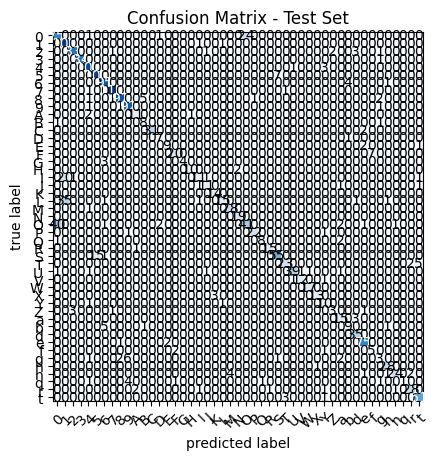

In [18]:
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, class_names=class_names)
plt.title('Confusion Matrix - Test Set')
plt.show()


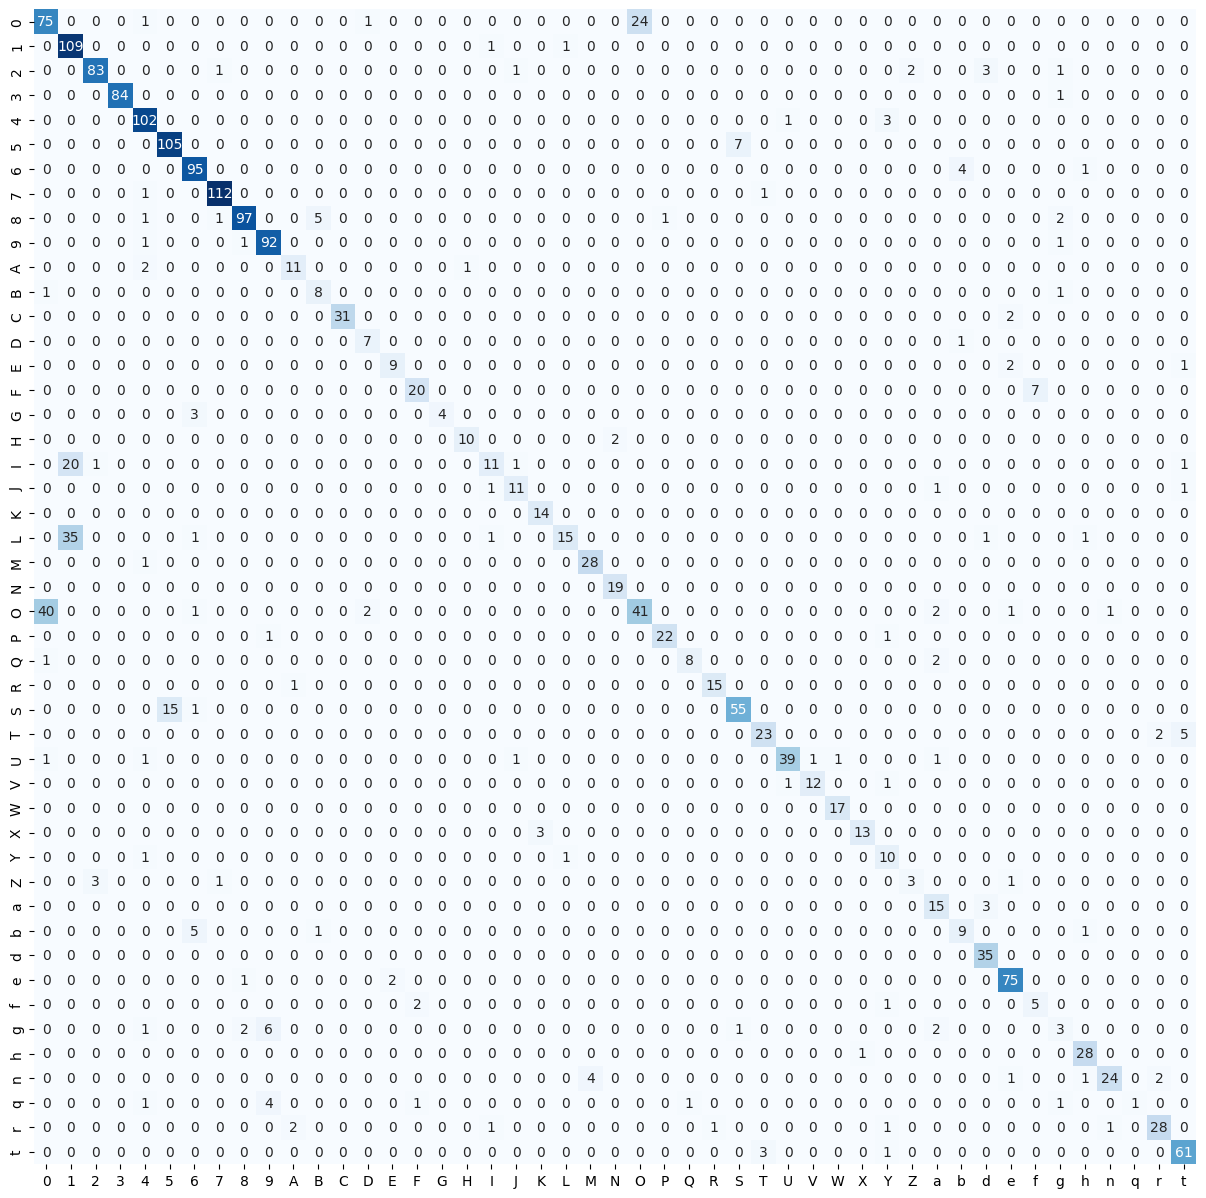

In [19]:
df_cm = pd.DataFrame(conf_matrix, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.show()


In [40]:

# Convert the list to a NumPy array
y_pred_20_train = np.array(y_pred_20_train)
y_true_20_train = np.array(y_true_20_train)

# Ensure both arrays are at least 1-dimensional and convert values to integers
y_true_20_train = np.atleast_1d(y_true_20_train).astype(int)
y_pred_20_train = np.atleast_1d(y_pred_20_train).astype(int)

# Create the dictionary mapping each class name to its integer value
class_to_int = {name: idx for idx, name in enumerate(class_names)}

# Create the reverse mapping dictionary
int_to_class = {idx: name for name, idx in class_to_int.items()}

# Map the integer values to class names
mapped_values = [int_to_class[y] for y in y_pred_20_train]

print("Mapped pred Values:", mapped_values)

# Map the integer values of y_true_20_train to class names
mapped_true_values = [int_to_class[y] for y in y_true_20_train]

print("Mapped True Values:", mapped_true_values)


Mapped pred Values: ['S', 'F', 'g', '3', '3', '1', 'O', '1', '7', 'S', '2', 'W', '0', '6', 'r', '5', '7', '4', 'U', '2', 'r', '5', 'O', 'r', 't', '6', '1', '1', 'S', 'Z', '1', '5', 'T', 't', '1', '8', 'S', '7', '7', 'I', '4', '4', '4', 'e', 'Z', 'A', '8', '1', '0', 'h', '0', '2', 'N', '5', '6', 'U', '0', '1', '5', 'C', 'X', '1', 'N', '5', '2', '6', 'O', '5', 'S', '1', '1', 'S', 'a', '1', 'P', 't', 'N', '6', '1', '3', '8', '3', '6', 'J', 'h', '0', '8', 'r', 'C', '5', 'M', '5', '6', 'N', '1', 'F', 'W', '1', '9', 'K', 'H', '2', 't', '6', '0', '4', 'e', '1', '4', 'g', '0', 'D', 'F', '9', 'A', 'B', '2', 'T', 'F', '4', 'e', '0', 't', '8', '8', 'r', 'L', 'O', '3', 'h', '5', 'A', '8', '9', '0', '0', 'G', '1', 'U', '5', '4', 'e', 'X', 't', '7', 'U', '5', '2', '6', 't', '7', 't', '5', '8', '9', '8', '2', 'n', 'E', 'V', '7', '8', '6', '5', 'b', 'Y', '6', 'M', '0', '4', '7', '1', 'a', '7', 'M', '1', '4', '0', '2', '0', 'C', 't', 't', 'a', '6', '5', '5', '6', '1', 'O', 'f', 'd', 't', 'W', 'J', '8',